### Bag of Visual Words Applied to Image Classification

### Libraries

In [1]:
import sys
sys.path.append('../src/') # Add src to path

from bovw import BagOfVisualWords
from elm import ELMClassifier

from glob import glob
import os
import numpy as np
import cv2
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

### Functions

In [2]:
def load_data(data_path, file_prefix='*.jpg'):

    dir_list = glob(data_path + '*') # Get the list of directories of each class

    dir_list = sorted(dir_list, key=len) # Order the list of directories by length

    # Get the image and label list (tuple)
    xy_tuple = [(cv2.imread(image, 0), int(f'{c[-1]}')) for c in dir_list for image in glob(os.path.join(c, file_prefix))]

    x_list, y_list = zip(*xy_tuple) # Unzip the tuple

    X = np.array(x_list)
    y = np.array(y_list)

    return X, y

In [3]:
def visual_words(X, bag):

    N = len(X) # Number of images
    K = bag.n_clusters # Number of visual words

    # SIFT object
    sift = cv2.SIFT_create()

    # Feature vector histogram: new and better representation of the images
    feature_vector = np.zeros((N, K))
    visial_word_pos = 0 # Position of the visual word

    # For each image
    for i in range(N):

        # Extract the keypoints descriptors of the current image
        _, curr_des = sift.detectAndCompute(X[i], None)

        # Define the feature vector of the current image
        feature_vector_curr = np.zeros(bag.n_clusters, dtype=np.float32)

        # Uses the BoVW to predict the visual words of each keypoint descriptors of the current image
        word_vector = bag.predict(np.asarray(curr_des, dtype=float))
        
        # For each unique visual word
        for word in np.unique(word_vector):
            res = list(word_vector).count(word) # Count the number of word in word_vector
            feature_vector_curr[word] = res # Increments histogram for that word
        
        # Normalizes the current histogram
        cv2.normalize(feature_vector_curr, feature_vector_curr, norm_type=cv2.NORM_L2)

        feature_vector[visial_word_pos] = feature_vector_curr # Assined the current histogram to the feature vector
        visial_word_pos += 1 # Increments the position of the visual word

    return feature_vector

### Data

Load the data used in this notebook.

In [4]:
TRAIN_PATH = '../data/training/'
TEST_PATH = '../data/test/'
FILE_PREFIX = '*.jpg'

Xtrain, ytrain = load_data(TRAIN_PATH, FILE_PREFIX)
Xtest, ytest = load_data(TEST_PATH, FILE_PREFIX)

print(f'Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}')
print(f'Xtest shape: {Xtest.shape}, ytest shape: {ytest.shape}')

Xtrain shape: (75, 200, 175), ytrain shape: (75,)
Xtest shape: (9, 200, 175), ytest shape: (9,)


Visualize some images in the data.

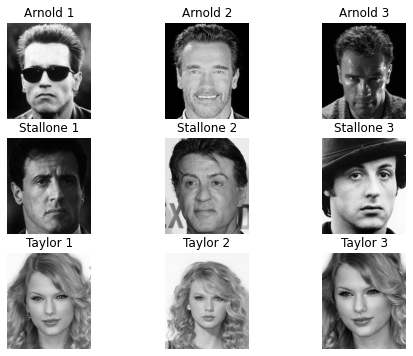

In [5]:
index = [0, 1, 2, 26, 27, 28, 51, 52, 53]
labels = ['Arnold 1', 'Arnold 2', 'Arnold 3',
          'Stallone 1', 'Stallone 2', 'Stallone 3',
          'Taylor 1', 'Taylor 2', 'Taylor 3']

Xsamples = Xtrain[index]
ysamples = ytrain[index]

figsize = (8, 6)

fig, axes = plt.subplots(3, 3, figsize=figsize)

for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(Xsamples[idx]), cmap="gray")
    ax.set_title(f"{labels[idx]}")
    ax.axis("off")

plt.show()

### Pipeline

Define the pipeline parameters:
- Number of clusters: 100.
- Number of hidden layers: 81.
- Random state: 24.

In [6]:
param = (100, 88, 10)

pipe = Pipeline([('BOVW', BagOfVisualWords(n_clusters=param[0])),
                     ('Classifier', ELMClassifier(L=param[1], random_state=param[2]))])

Fit the pipeline with the bag of visual words (BOVW) and extreme learning machine (ELM) classifier.

In [7]:
pipe.fit(Xtrain, ytrain)

Pipeline(steps=[('BOVW', BagOfVisualWords(n_clusters=100)),
                ('Classifier', ELMClassifier(L=88, random_state=10))])

Assign pipeline objects to variables.

In [8]:
bovw = pipe[0] # Bag of visual words
elm = pipe[1] # ELM classifier

Show the parameters of the BOVW.

In [9]:
for c in bovw.labels_dict:
    print(f'Class {c}: {len(bovw.labels_dict[c]["kp"])} features')

Class 0: 4225 features
Class 1: 3750 features
Class 2: 2025 features


In [10]:
print(f'{bovw.n_descriptors} keypoints of each label are used to create the visual vocabulary')
print(f'Cluster {bovw.n_features} features into {bovw.n_clusters} visual words.')

1620 keypoints of each label are used to create the visual vocabulary
Cluster 4860 features into 100 visual words.


Results of the pipeline.

In [11]:
pred = pipe.predict(Xtrain)
train_acc = accuracy_score(ytrain, pred)

pred = pipe.predict(Xtest)
test_acc = accuracy_score(ytest, pred)

print(f'Parameters: {param}, train accuracy: {train_acc*100} %, test accuracy: {test_acc*100} %')

Parameters: (100, 88, 10), train accuracy: 100.0 %, test accuracy: 100.0 %


### Investigation of an example

Show the image and its keypoints.

Keypoint descriptors shape: (200, 128)


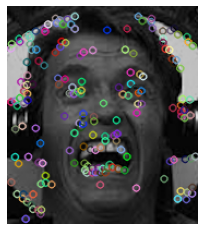

In [12]:
image = cv2.imread('../data/training/label_0/arnold12.jpg', 0)

sift = cv2.SIFT_create()

kp, des = sift.detectAndCompute(image, None)

img = cv2.drawKeypoints(image, kp, image)

print(f'Keypoint descriptors shape: {des.shape}')

plt.imshow(img)
plt.axis("off")
plt.show()

Visualize the feature vector of the investigated image.

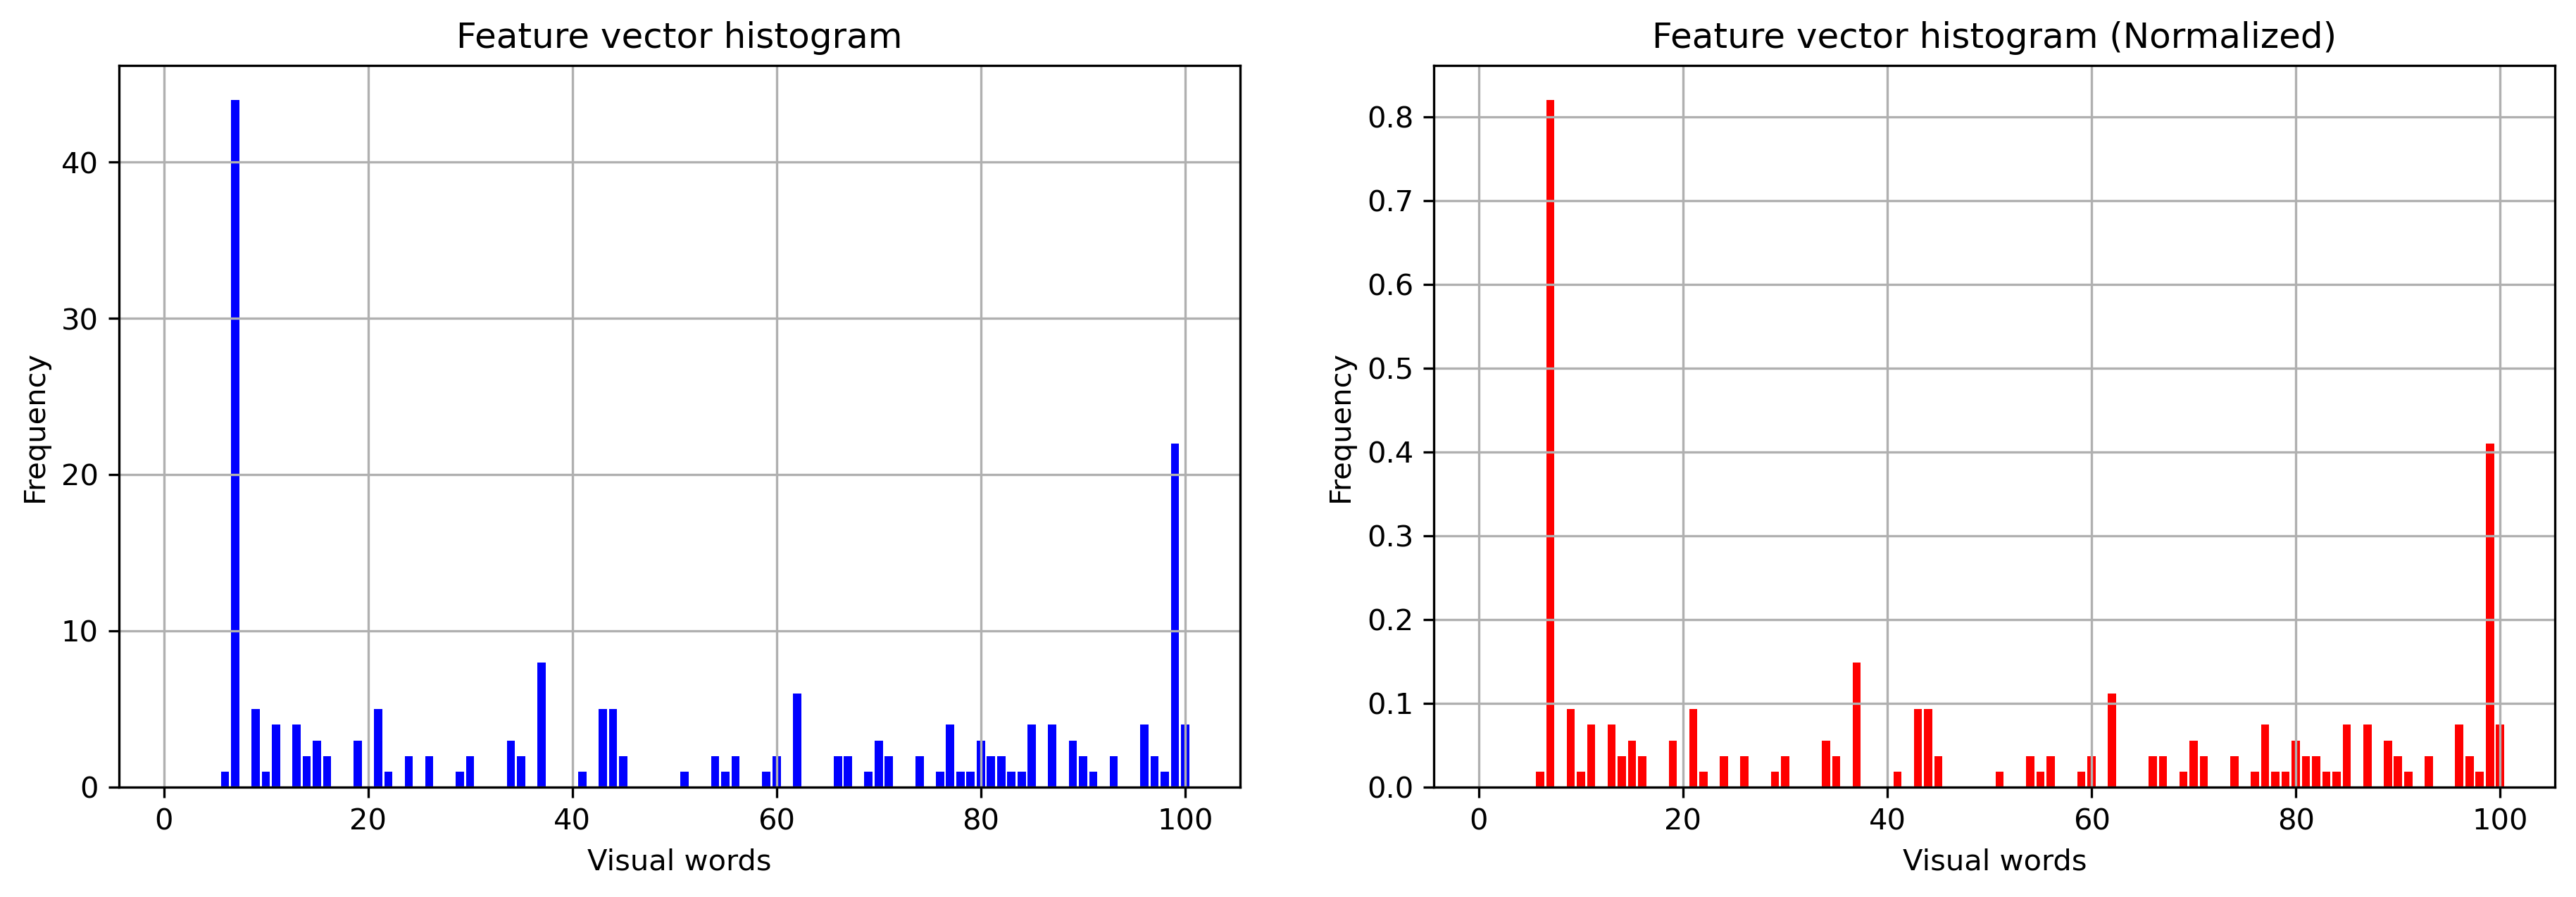

In [13]:
# Extract the keypoints descriptors of the current image
_, des = sift.detectAndCompute(image, None)

# Define the feature vector of the current image
feature_vector = np.zeros(bovw.bag.n_clusters, dtype=np.float32)

# Uses the BoVW to predict the visual words of each keypoint descriptors of the current image
word_vector = bovw.bag.predict(np.asarray(des, dtype=float))

# For each unique visual word
for word in np.unique(word_vector):
    res = list(word_vector).count(word) # Count the number of word in word_vector
    feature_vector[word] = res # Increments histogram for that word

# Normalizes the current histogram
feature_vector_normalized = np.zeros(bovw.bag.n_clusters, dtype=np.float32)
cv2.normalize(feature_vector, feature_vector_normalized, norm_type=cv2.NORM_L2)

_, axes = plt.subplots(1,2, figsize=(8,4), dpi=300)
plt.tight_layout()

feature_vectors = [feature_vector, feature_vector_normalized]
color_list = ['blue', 'red']
title_list = ['Feature vector histogram', 'Feature vector histogram (Normalized)']

for i in range(len(axes)):
    axes[i].bar(np.arange(1, len(feature_vectors[i])+1), feature_vectors[i], color=color_list[i])
    axes[i].set_xlabel('Visual words')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(title_list[i])
    axes[i].grid()

plt.subplots_adjust(right=1.5)

plt.show()

Keypoints and visual vocabulary.

In [14]:
max_kp_des = int(np.max(feature_vector))
visual_word = np.where(feature_vector == np.max(feature_vector))[0][0]

print(f'{max_kp_des} keypoints descriptors are assigned as visual word {visual_word}.')

44 keypoints descriptors are assigned as visual word 6.


Probability distribuition and label prediction

In [15]:
labels_list = ['Arnold Schwarzenegger', 'Silvester Stallone', 'Taylor Swift']

h, w = image.shape
input_image = image.reshape(-1, h, w)

feature_vector = bovw.transform(input_image)
proba = elm.predict_proba(feature_vector)[0]

print(f'Probability distribuition: {proba}')
print(f'Probability of {np.max(proba)*100:.2f}% being {labels_list[np.argmax(proba)]} (label {np.argmax(proba)})')

Probability distribuition: [0.57611688 0.21194156 0.21194156]
Probability of 57.61% being Arnold Schwarzenegger (label 0)


### Save and load the models

Save the BoVW.

In [16]:
# Save the bag of visual words
joblib.dump(bovw.bag, '../models/bovw.joblib')

['../models/bovw.joblib']

Save the ELM classifier.

In [17]:
# Save the ELM classifier

joblib.dump(elm, '../models/elm.joblib')

['../models/elm.joblib']

Load BoVW and ELM

In [18]:
bovw = joblib.load('../models/bovw.joblib')
elm = joblib.load('../models/elm.joblib')

Load the test data.

In [19]:
TEST_PATH = '../data/test/'
FILE_PREFIX = '*.jpg'

Xtest, ytest = load_data(TEST_PATH, FILE_PREFIX)

print(f'Xtest shape: {Xtest.shape}, ytest shape: {ytest.shape}')

Xtest shape: (9, 200, 175), ytest shape: (9,)


Predict the loaded data.

In [22]:
Xtest_vector = visual_words(Xtest, bovw)
pred = elm.predict(Xtest_vector)
test_acc = accuracy_score(ytest, pred)

print(f'Test accuracy: {test_acc*100} %')

Test accuracy: 100.0 %
